In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

# 读取数据集

In [2]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read() #读取整个文本
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [226]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size:{len(vocab)}'

'vocab size:6719'

# 下采样
1. "the","in","and"等高频词常在上下文窗口中与许多不同的词共同出现，提供的有用信息很少
2. 对高频单词进行下采样,每个词$\omega_{i}$被丢弃的概率为：
$$P(\omega_{i}) = max(1-\sqrt\frac{t}{f(\omega_{i})},0)$$
$f(\omega_{i}$为词$\omega_{i}$的词数与数据集中的总词数的比率；\
当$f(\omega_{i}) > t$,$P(\omega_{i}) = 1-\sqrt\frac{t}{f(\omega_{i})}$\
当$f(\omega_{i}) < t$,$P(\omega_{i}) =0 $

In [18]:
import collections
#统计词频
def count_corpus(tokens):
    if len(tokens)== 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line ]
    return collections.Counter(tokens)

def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token]!=0]
                 for line in sentences]
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())
    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return (random.uniform(0,1) < math.sqrt(1e-4/(counter[token]/num_tokens)))
    
    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

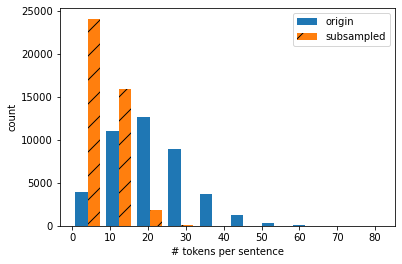

In [25]:
import matplotlib.pyplot as plt
def show_list_len_pair_hist(legend, xlabel,ylabel,xlist,ylist):
    """绘制列表长度对的直方图"""
    _,_,patches = plt.hist([[len(l) for l in xlist],[len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [154]:
def compare_counts(token):
    """统计单个词在采样前后的总数量"""
    return (f'"{token}"的数量: '
            f'之前={sum([l.count(token) for l in sentences])}'
            f'之后={sum([l.count(token) for l in subsampled])}')

print(compare_counts('the'))
print(compare_counts('happy'))

"the"的数量: 之前=50770之后=2036
"happy"的数量: 之前=24之后=24


In [155]:
#在下采样之后，将词元映射到它们在语料库中的索引
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [2115, 18, 406], [5277, 3054, 1580]]

# 中心词和上下文词的提取
从corpus中提取所有的中心词和上下文词\
随机采样1到max_window_size之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。

In [156]:
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [],[]
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line #列表中所有均为元素，不存在嵌套子列表
        #保存每个中心词的上下文词
        for i in range(len(line)):
            #随机采样窗口大小
            window_size = random.randint(1,max_window_size)
            #上下文词索引
            indices = list(range(max(0,i-window_size),
                                 min(len(line),i+window_size+1)))
            # 从上下文中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])#将整个列表添加进大列表中
    return centers, contexts

all_centers, all_contexts = get_centers_and_contexts(corpus,5)
f'#"中心词-上下文词对"的数量为{sum([len(context) for context in all_contexts])}'          

'#"中心词-上下文词对"的数量为1498955'

In [228]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [1, 3]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]


# 负采样
+ 根据预定义的分布对噪声词进行采样，添加负例样本

In [158]:
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self,sampling_weights):
        #Exclude
        self.population = list(range(1,len(sampling_weights)+1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        
    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(self.population,
                                             self.sampling_weights,k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [59]:
sampling_weights = [2, 3, 4]
population = list(range(1,len(sampling_weights)+1))
print(population)
random.choices(population,sampling_weights,k=10)

[1, 2, 3]


[2, 3, 3, 3, 3, 2, 3, 3, 1, 1]

In [60]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]#取前10个采样值

[1, 3, 1, 3, 3, 2, 3, 2, 3, 3]

In [229]:
def get_negatives(all_contexts,vocab,counter,K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    # counter为词表中词对应的词频（字典）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                       for i in range(1,len(vocab))]#获取每个词对应的权重
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:#生成不小于len(contexts) * K个数量的负样样本
            neg = generator.draw()
            #噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives #每个中心词对应的噪声词

all_negatives = get_negatives(all_contexts, vocab,counter, 5)
all_negatives[:4]

[[3512, 759, 770, 2720, 997],
 [541, 516, 674, 12, 461, 1821, 1135, 6032, 1247, 904],
 [249, 227, 5796, 1086, 29],
 [10, 1964, 41, 343, 3720, 1004, 145, 1714, 45, 3416]]

# 小批量加载训练实例

In [230]:
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    '''data中每个元素是由中心词center、
    其上下文词context和其噪声词negative组成
    为保证每个样本的输入长度相同，进行填充，定义掩码mask
    context_negatives将其上下文词和噪声词连结起来，并填充零
    mask与contexts_negatives中元素一一对应，0对应填充
    labels中的1（否则为0）对应于contexts_negatives中的上下文词的正例'''
    max_len = max(len(c)+len(n) for _,c,n in data)
    centers, contexts_negatives, masks, labels = [],[],[],[]
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers.append(center)
        contexts_negatives += [context+negative+[0]*(max_len-cur_len)]
        masks += [[1]*cur_len + [0]*(max_len-cur_len)]
        labels += [[1]*len(context) + [0]*(max_len-len(context))]
        
    return (torch.tensor(centers).reshape(-1,1), torch.tensor(
    contexts_negatives),torch.tensor(masks), torch.tensor(labels))

x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1,x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name,data in zip(names,batch):
    print(name,"=" , data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


# 数据预处理总结

In [231]:
from torch.utils.data import Dataset, DataLoader
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences,min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts,vocab,counter,num_noise_words)

    class PTBDataset(Dataset):
        def __init__(self,centers,contexts,negatives):
            # 不满足条件立即报错
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives
        def __getitem__(self,index):
            return (self.centers[index],self.contexts[index],
                   self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers,all_contexts,all_negatives)

    data_iter = DataLoader(dataset, batch_size,shuffle=True,
                          collate_fn=batchify)

    return data_iter, vocab

In [232]:
data_iter, vocab = load_data_ptb(512,5,5)
for batch in data_iter:
    for name, data in zip(names,batch):
        print(name,"shape:",data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# 预训练word2vec

In [233]:
import math
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

# Skip-gram模型
## 1.嵌入层
+ 将词元的索引映射到其特征向量,该层的权重是一个矩阵，其行数等于字典大小（input_dim），列数等于每个标记的向量维数（output_dim）

In [234]:
embed = nn.Embedding(num_embeddings=20,embedding_dim=4)
print(f'Parameter embeding_weight({embed.weight.shape},dtype={embed.weight.dtype})')

Parameter embeding_weight(torch.Size([20, 4]),dtype=torch.float32)


In [149]:
X =torch.tensor([[1,2,3],[4,5,6]])
embed(X).shape

torch.Size([2, 3, 4])

## 2.前向传播
跳元语法模型
+ 输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives
+ 输出中的每个元素是中心词向量和上下文或噪声词向量的点积。

In [235]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

# 训练
## 1.二元交叉熵损失

In [236]:
class SigmoidBCELoss(nn.Module):
    # 带掩码的二元交叉熵损失
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

In [123]:
pred = torch.tensor([[1.1,-2.2,3.3,-4.4]]*2)
label = torch.tensor([[1.0,0.0,0.0,0.0],[0.0,1.0,0.0,0.0]])
mask = torch.tensor([[1,1,1,1],[1,1,0,0]])
loss(pred,label,mask)*mask.shape[1]/mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [120]:
# ----------与二元交叉熵相同的结果
#使用二元交叉熵损失中的Sigmoid激活函数（以较低效率的方式）计算上述结果
def sigmd(x):
    return -math.log(1/(1+math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


## 2.初始化模型参数

In [237]:
# 定义两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size))

In [183]:
torch.cuda.is_available()
device

device(type='cuda')

## 3.定义训练阶段代码

In [242]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
def train(net,data_iter,lr,num_epochs,device):
    def init_weight(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    net = net
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',
                           xlim=[1,num_epochs])
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batchs = d2l.Timer(),len(data_iter)
        for i,batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data for data in batch]
            pred = skip_gram(center,context_negative,net[0],net[1])
            l = (loss(pred.reshape(label.shape).float(),label.float(),mask)*mask.shape[1]/mask.sum(axis=1))
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(),l.numel())#记录样本损失总和以及样本长度
            if (i+1)%(num_batchs //5) == 0 or i==num_batchs-1 :
                animator.add(epoch+(i+1)/num_batchs,(metric[0]/metric[1]))
    print(f'loss{metric[0]/metric[1]:.3f},'
         f'{metric[1]/timer.stop():.1f} tokens/sec on {str(device)}')
            

loss0.410,30492.5 tokens/sec on cuda


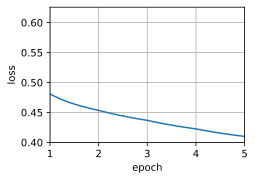

In [243]:
lr, num_epochs = 2e-3, 5
train(net, data_iter,lr,num_epochs,device)

In [245]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data#词向量矩阵[len(vocab),embed_size]
    x = W[vocab[query_token]]
    #计算余弦相似度，增加1e-9以获得数值稳定性
    # torch.mv(W,x)表示矩阵与向量的相乘
    cos = torch.mv(W,x)/torch.sqrt(torch.sum(W*W,dim=1)*
                                   torch.sum(x*x)+1e-9)
    #topk 返回降序后的前k个大小的元素值及索引
    topk = torch.topk(cos,k=k+1)[1].numpy().astype('int32')
    for i in topk[1:]: # 删除输入词
        print(f'cosine sim={float(cos[i]):.3f}:{vocab.to_tokens(i)}')

get_similar_tokens('chip',3,net[0])

cosine sim=0.677:microprocessor
cosine sim=0.596:desktop
cosine sim=0.574:laptop


In [262]:
query_token = "love"
W = net[0].weight.data#词向量矩阵[len(vocab),embed_size]
x = W[vocab[query_token]]
torch.mv(W,x)

tensor([-0.0348,  1.0878, -0.4111,  ...,  1.2526,  0.0584,  2.8232])